## Library

In [2]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import *

In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
from gensim import models

## word2vec model <br>(stopwords removed / 300 dimension) 

In [5]:
okt_model = models.word2vec.Word2Vec.load('NaverMovie_okt_wo_sw.model')

## train/test set

In [7]:
train_data = pd.read_csv('ratings_train.txt',sep='\t').dropna().reset_index(drop=True)
test_data = pd.read_csv('ratings_test.txt',sep='\t').dropna().reset_index(drop=True)

training_sentences = []
testing_sentences = []

In [8]:
documents = []
for item in train_data.document:
    documents.append(item)

labels = []
for item in train_data.label:
    labels.append(item)

In [9]:
test_documents = []
for item in test_data.document:
    test_documents.append(item)

test_labels = []
for item in test_data.label:
    test_labels.append(item)

In [16]:
training_labels_final = np.array(labels)
testing_labels_final = np.array(test_labels)

## Padding

In [10]:
vocab_size = 20000
embedding_dim = 300
max_length = 41
trunc_type='post'
oov_tok = '<OOV>'

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(documents)

In [11]:
word_index = tokenizer.word_index
text_sequences = tokenizer.texts_to_sequences(documents)
padded = pad_sequences(text_sequences,maxlen=max_length,truncating = 'pre')

In [12]:
testing_sequences = tokenizer.texts_to_sequences(test_documents)
test_padded = pad_sequences(testing_sequences, maxlen=max_length)

In [13]:
len(word_index)

296311

In [14]:
print(padded[0])
print(padded.shape)

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0   24  937    5 6728 1098]
(149995, 41)


## embedding matrix

In [15]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))

index = 0 
for word, idx in tokenizer.word_index.items():
    try:
        embedding_vector = okt_model.wv.__getitem__(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
    except Exception as e:
        pass
        
embedding_matrix.shape

(20000, 300)

## Layers

In [17]:
sequence_input = tf.keras.Input(shape=(max_length,), dtype='int32')
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                            embedding_dim,
                            input_length=max_length,
                            trainable=False)
embedded_sequences = embedding_layer(sequence_input)
convs = []
filter_sizes = [3,4,5]
for fsz in filter_sizes:
    x = tf.keras.layers.Conv1D(128, fsz, activation='relu',padding='same')(embedded_sequences)
    x = tf.keras.layers.MaxPooling1D()(x)
    convs.append(x)
x = tf.keras.layers.Concatenate(axis=-1)(convs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, output)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## Training

In [18]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss',min_delta=0.002,patience=1,mode='min')

In [20]:
num_epochs = 30
history = model.fit(padded, training_labels_final, epochs = num_epochs, validation_data = (test_padded, testing_labels_final),callbacks=[es])
history

Epoch 1/30
4688/4688 [==============================] - 111s 24ms/step - loss: 0.2470 - accuracy: 0.8783 - val_loss: 0.6619 - val_accuracy: 0.7535
Epoch 2/30
4688/4688 [==============================] - 112s 24ms/step - loss: 0.2212 - accuracy: 0.8910 - val_loss: 0.7094 - val_accuracy: 0.7510


In [21]:
sentence = ["존나 재미없다","개꿀잼"]
sequence_exp = tokenizer.texts_to_sequences(sentence)
padded_exp = pad_sequences(sequence_exp, maxlen = max_length, truncating= 'post')
print(model.predict(padded_exp).round(2))

[[0.  ]
 [0.97]]


## Save model

In [22]:
model.save('word2vec_okt300_model/0.75_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: word2vec_okt300_model/0.75_model/assets


## Load model and Re-training

In [26]:
okt_remodel = tf.keras.models.load_model('word2vec_okt300_model/0.75_model')

In [27]:
es = EarlyStopping(monitor='val_accuracy',min_delta=0.002,patience=1,mode='max')
history = okt_remodel.fit(padded, training_labels_final, epochs = num_epochs, validation_data = (test_padded, testing_labels_final),callbacks=[es])

Epoch 1/30
4688/4688 [==============================] - 777s 166ms/step - loss: 0.3828 - accuracy: 0.8220 - val_loss: 0.4144 - val_accuracy: 0.8038
Epoch 2/30
4688/4688 [==============================] - 370s 79ms/step - loss: 0.2161 - accuracy: 0.8971 - val_loss: 0.5371 - val_accuracy: 0.7931


In [ ]:
model.save('word2vec_okt300_model/0.75_model')

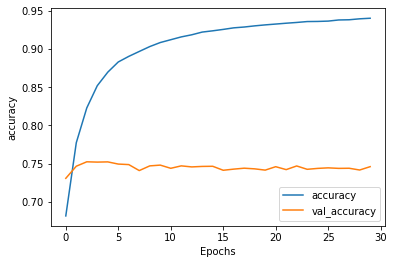

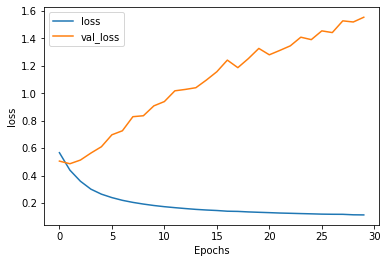

In [31]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')